In [ ]:
!pip install openpyxl

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [ ]:
# Load your dataset from Excel
file_path = '/content/Dataset.xlsx'
df = pd.read_excel(file_path)

In [ ]:
# Shuffle the DataFrame rows randomly
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.head()

,γ,C,D,H,n,β,λ 2 (Å−1),B (eV),R (Å),D (Å),λ 1 (Å−1),A (eV),Fracture_strength
0,1.000479,38225.269271,4.329915,-0.571657,0.725853,1.567065e-07,2.216766,347.891095,1.950319,0.149704,3.471353,1389.201981,119.8
1,0.993235,38103.682397,4.281624,-0.563055,0.731138,1.546876e-07,2.218992,352.979516,1.969501,0.148222,3.429635,1417.799233,107.5
2,1.019167,37680.076750,4.409634,-0.571610,0.728171,1.581108e-07,2.216717,346.760980,1.974129,0.150031,3.489415,1395.199840,119.3
3,0.994927,38090.016798,4.298250,-0.564936,0.730227,1.553217e-07,2.217164,351.409637,1.964626,0.148667,3.444199,1411.749425,110.5
4,0.995546,38206.893084,4.361360,-0.571712,0.730717,1.576466e-07,2.218948,346.453517,1.941314,0.150282,3.471801,1394.195262,117.3


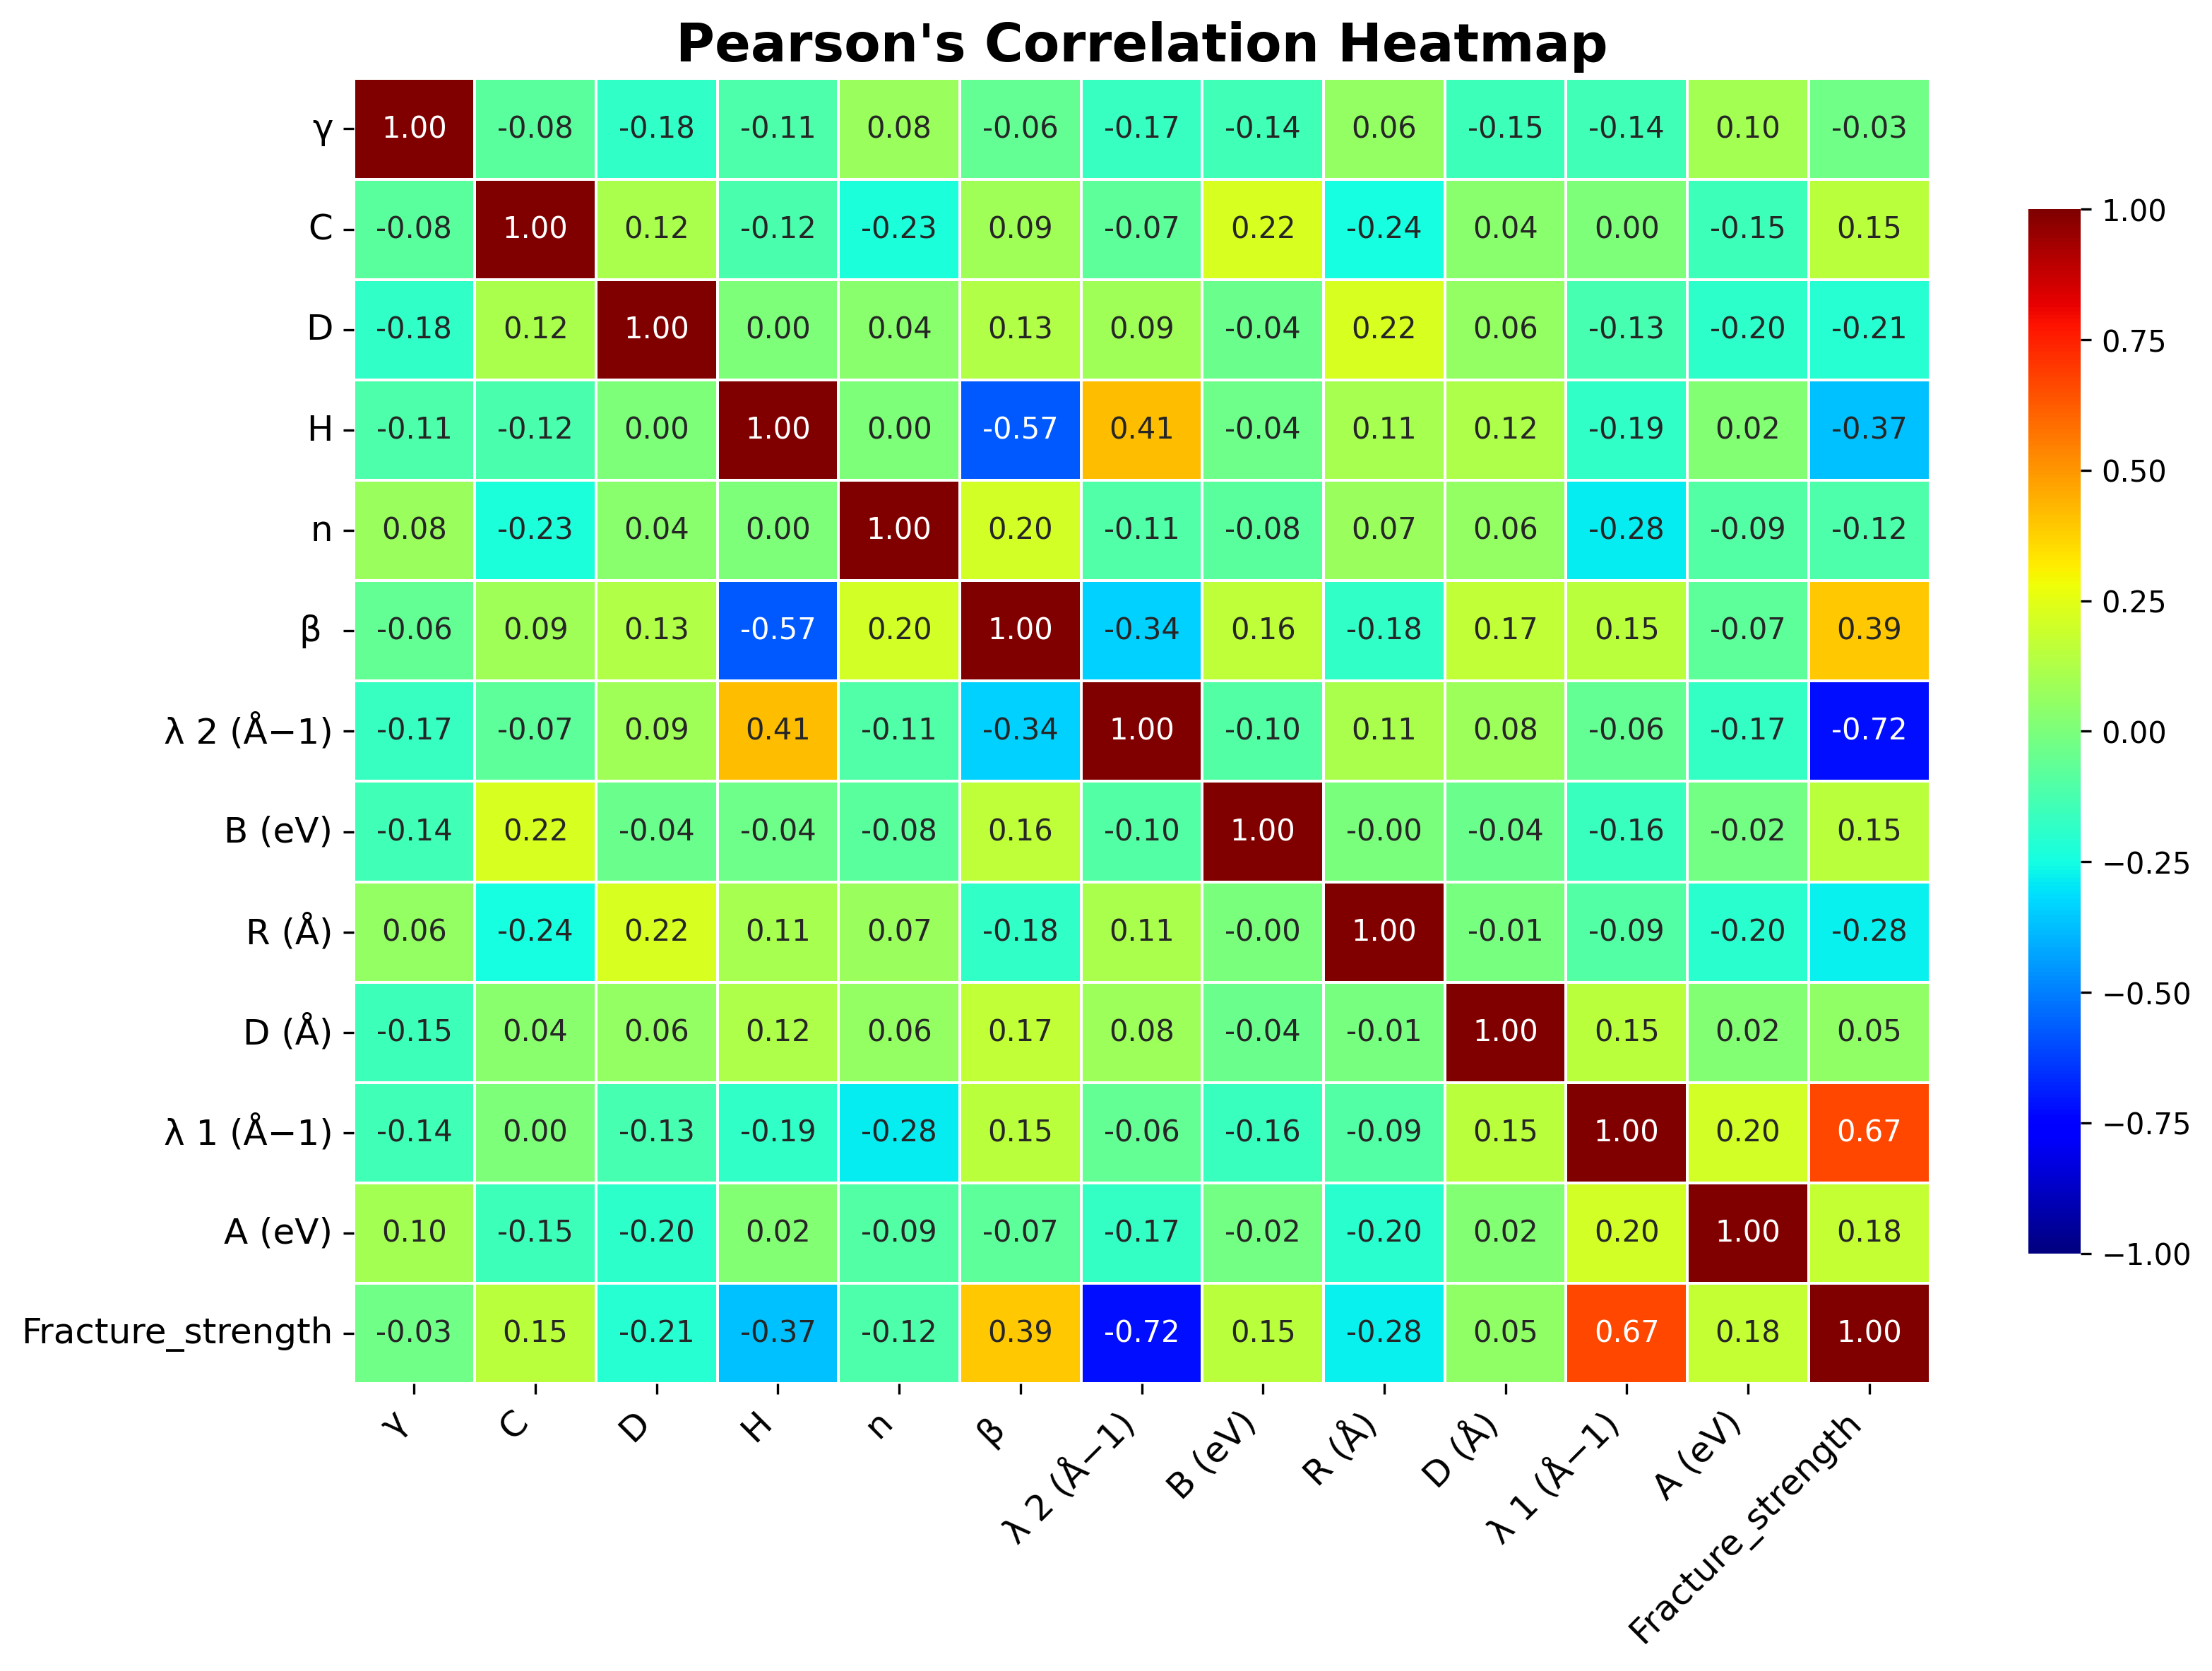

In [ ]:
# Pearson's Correlation Analysis
plt.figure(figsize=(12, 8), dpi=300)
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='jet', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8}, vmax=1.0, vmin=-1.0)
plt.title("Pearson's Correlation Heatmap", fontsize=18, fontweight='bold')
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.savefig("Pearson.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Indentifying Input features (X), and Responses (y1, y2, and y3)
X = df.iloc[:, 0:12]
y = df.iloc[:, 12]
X.head()

,γ,C,D,H,n,β,λ 2 (Å−1),B (eV),R (Å),D (Å),λ 1 (Å−1),A (eV)
0,1.000479,38225.269271,4.329915,-0.571657,0.725853,1.567065e-07,2.216766,347.891095,1.950319,0.149704,3.471353,1389.201981
1,0.993235,38103.682397,4.281624,-0.563055,0.731138,1.546876e-07,2.218992,352.979516,1.969501,0.148222,3.429635,1417.799233
2,1.019167,37680.076750,4.409634,-0.571610,0.728171,1.581108e-07,2.216717,346.760980,1.974129,0.150031,3.489415,1395.199840
3,0.994927,38090.016798,4.298250,-0.564936,0.730227,1.553217e-07,2.217164,351.409637,1.964626,0.148667,3.444199,1411.749425
4,0.995546,38206.893084,4.361360,-0.571712,0.730717,1.576466e-07,2.218948,346.453517,1.941314,0.150282,3.471801,1394.195262


In [ ]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

In [ ]:
# Define a function to train and tune a GPR model
def train_gpr(X_train, Y_train):
    # Define a pipeline with feature scaling and GPR
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('gpr', GaussianProcessRegressor())
    ])

    # Define the hyperparameter grid
    param_grid = {
        'gpr__kernel': [
            C(1.0) * RBF(length_scale) for length_scale in [0.1, 1.0, 10.0]
        ],
        'gpr__alpha': [1e-10, 1e-5, 1e-2]
    }

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, Y_train)

    return grid_search.best_estimator_, grid_search.best_params_

In [ ]:
# Train and tune the GPR models
best_gpr, best_params = train_gpr(X_train, y_train)

In [ ]:
# Cross-validation scores
cv_scores_GPR = cross_val_score(best_gpr, X_train, y_train.values.ravel(), cv=5, scoring='r2')

print("Best GPR parameters:", best_params)
print("GPR 5-fold CV R2 scores:", cv_scores_GPR)

Best GPR parameters: {'gpr__alpha': 0.01, 'gpr__kernel': 1**2 * RBF(length_scale=1)}
GPR 5-fold CV R2 scores: [0.84177398 0.93585797 0.76211057 0.93790066 0.83112308]


In [ ]:
# Predictions
y_train_pred = best_gpr.predict(X_train)
y_test_pred = best_gpr.predict(X_test)

# Evaluation
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("GPR R-squared (Train, Test):", r2_train, r2_test)
print("GPR MSE (Train, Test):", mse_train, mse_test)

GPR R-squared (Train, Test): 0.9999938148421563 0.9444597565929318
GPR MSE (Train, Test): 0.0008546180968186893 9.374640971083979


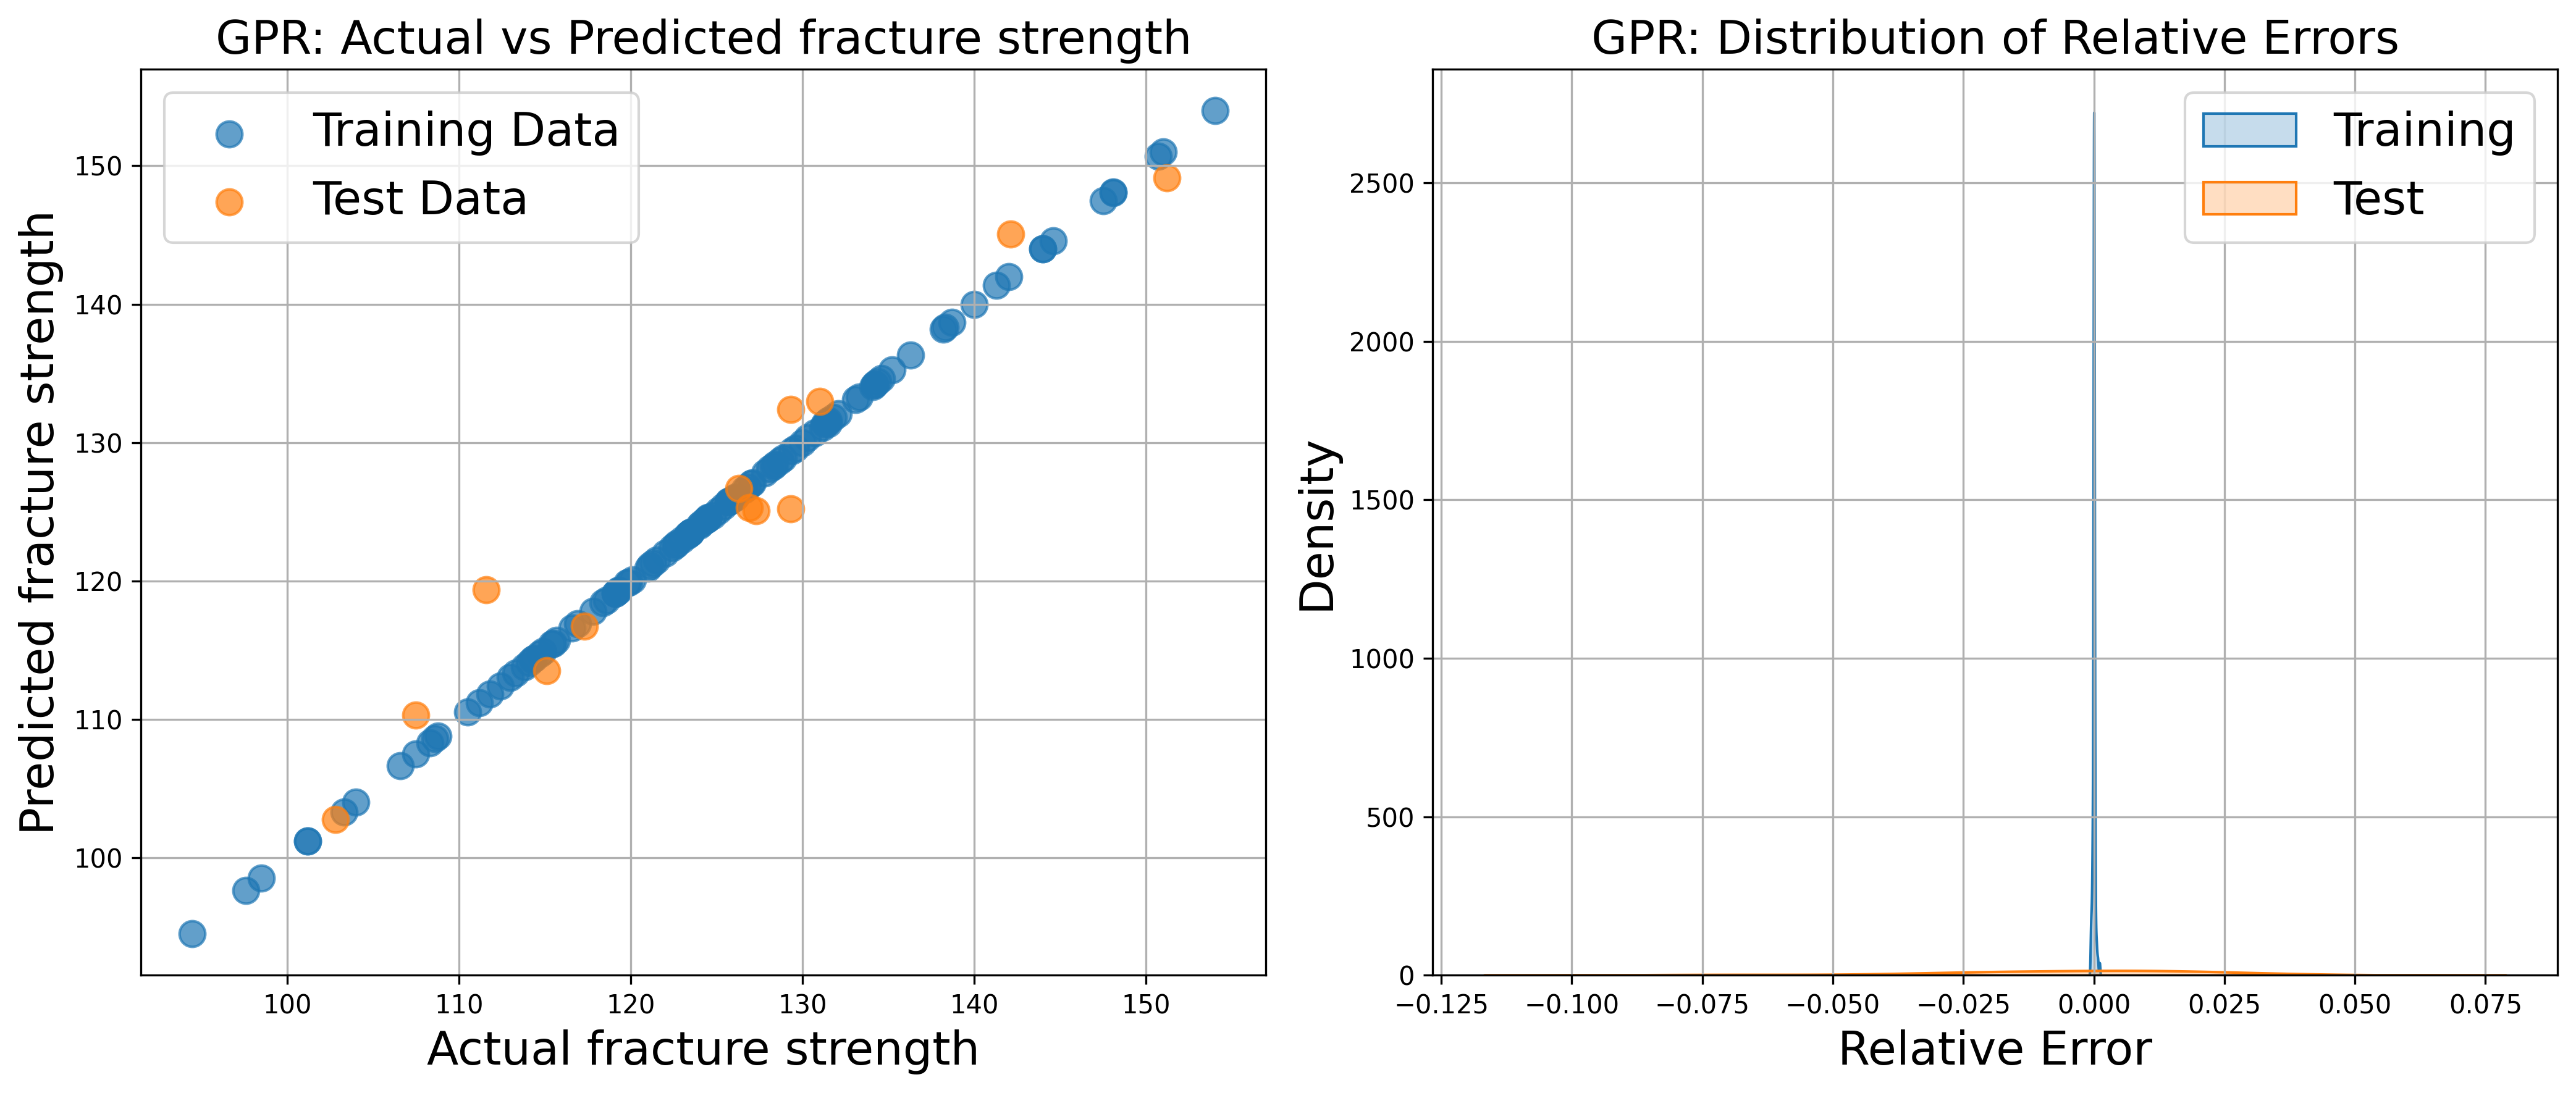

In [ ]:
# High-quality Regressor plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
axes[0].scatter(y_train, y_train_pred, label='Training Data', alpha=0.7, s=100)
axes[0].scatter(y_test, y_test_pred, label='Test Data', alpha=0.7, s=100)
axes[0].set_xlabel('Actual fracture strength', fontsize=18)
axes[0].set_ylabel('Predicted fracture strength', fontsize=18)
axes[0].set_title('GPR: Actual vs Predicted fracture strength', fontsize=18)
axes[0].legend(fontsize=18)
axes[0].grid(True)

# Relative error distribution
relative_error_gpr_train = (y_train - y_train_pred) / y_train
relative_error_gpr_test = (y_test - y_test_pred) / y_test


sns.kdeplot(relative_error_gpr_train, label='Training', fill=True, ax=axes[1])
sns.kdeplot(relative_error_gpr_test, label='Test', fill=True, ax=axes[1])
axes[1].set_xlabel('Relative Error', fontsize=18)
axes[1].set_ylabel('Density', fontsize=18)
axes[1].set_title('GPR: Distribution of Relative Errors', fontsize=18)
axes[1].legend(fontsize=18)
axes[1].grid(True)

plt.savefig("GPR_E.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [ ]:
# Load your dataset from Excel
file_path_1 = '/content/Internal_0.5_10000.xlsx'
df_1 = pd.read_excel(file_path_1)

# Load your dataset from Excel
file_path_2 = '/content/Internal_1_10000.xlsx'
df_2 = pd.read_excel(file_path_2)

# Load your dataset from Excel
file_path_3 = '/content/int_1.5%_10000.xlsx'
df_3 = pd.read_excel(file_path_3)

# Load your dataset from Excel
file_path_4 = '/content/int_2%_10000.xlsx'
df_4 = pd.read_excel(file_path_4)

In [ ]:
pred_df1 = best_gpr.predict(df_1)
pred_df2 = best_gpr.predict(df_2)
pred_df3 = best_gpr.predict(df_3)
pred_df4 = best_gpr.predict(df_4)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<ipython-input-18-d3022d4b6bbf>:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(pred_data, labels=['0.5%', '1.0%', '1.5%', '2.0%'])


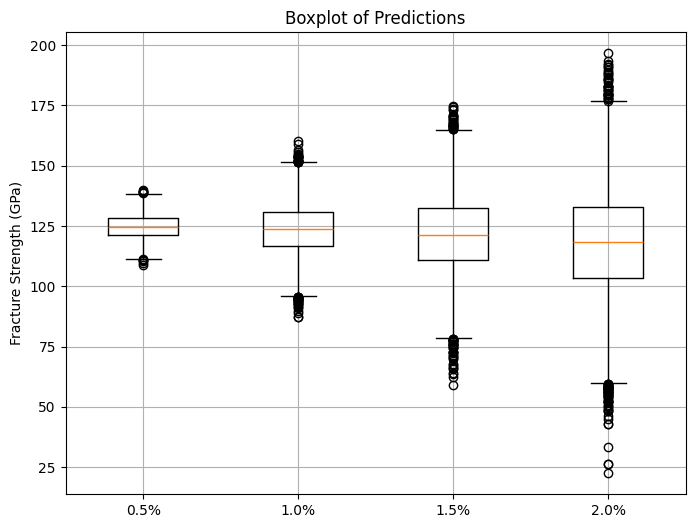

In [ ]:
# Combine all predictions into a list
pred_data = [pred_df1, pred_df2, pred_df3, pred_df4]

# Create the boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(pred_data, labels=['0.5%', '1.0%', '1.5%', '2.0%'])

# Add title and axis labels
plt.title('Boxplot of Predictions')
plt.ylabel('Fracture Strength (GPa)')
plt.grid(True)
plt.savefig("boxplots.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
!pip install shap

In [ ]:
import shap
# Extract scaler and model
scaler = best_gpr.named_steps['scaler']
gpr_model = best_gpr.named_steps['gpr']
X_scaled = scaler.transform(X)

In [ ]:
# Create SHAP KernelExplainer with 100-sample background
background = shap.utils.sample(X_scaled, 100, random_state=42)
explainer = shap.KernelExplainer(gpr_model.predict, background)

In [ ]:
# Calculate SHAP values for entire dataset
shap_values = explainer.shap_values(X_scaled)

  0%|          | 0/128 [00:00<?, ?it/s]

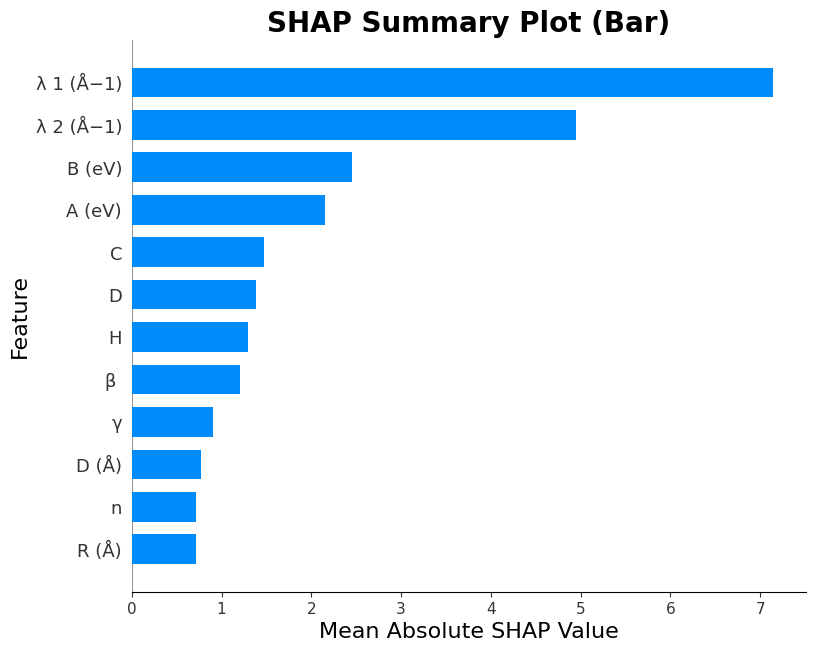

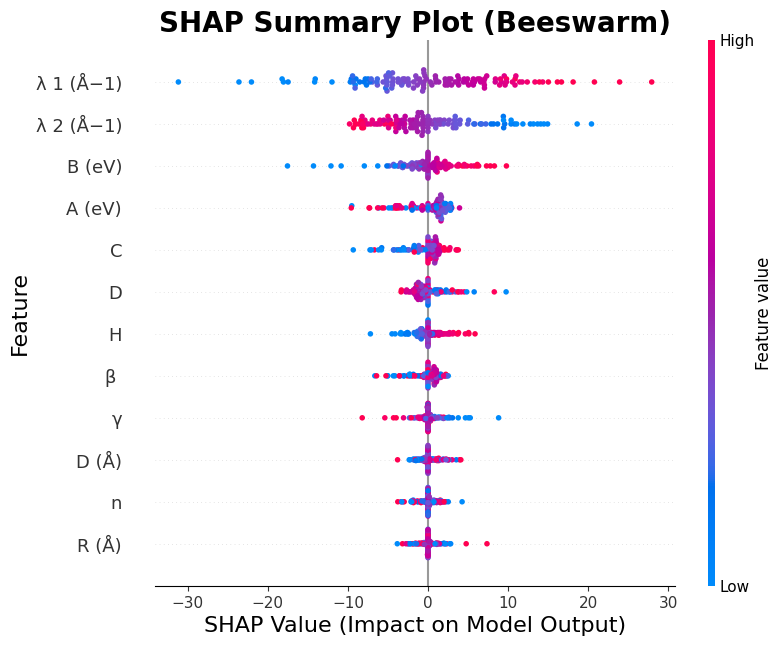

In [ ]:
# Plot summary SHAP bar chart
fig, ax = plt.subplots(figsize=(12, 8))
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.title("SHAP Summary Plot (Bar)", fontsize=20, fontweight='bold')
plt.xlabel("Mean Absolute SHAP Value", fontsize=16)
plt.ylabel("Feature", fontsize=16)
plt.savefig("shap_summary_bar.png", bbox_inches='tight')
plt.show()

# Detailed SHAP value distribution
fig, ax = plt.subplots(figsize=(12, 8))
shap.summary_plot(shap_values, X, show=False)
plt.title("SHAP Summary Plot (Beeswarm)", fontsize=20, fontweight='bold')
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=16)
plt.ylabel("Feature", fontsize=16)
plt.savefig("shap_summary_beeswarm.png", bbox_inches='tight')
plt.show()